In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.datasets import load_breast_cancer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import cross_val_score as cvs
from sklearn.pipeline import Pipeline as pp
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin 
class Clr (BaseEstimator,TransformerMixin):
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        xmean = stats.gmean(x,0)
        back = np.log(x/xmean)
        return back

In [3]:
dataset = pd.read_excel(r"Dataset/dataset_ML.xlsx")  #读取数据
dataset = dataset[dataset["outliers"] == "Non-outlier"]
cols = [
    'Genetic type', "Reference","Sample","Ce", 'Nd', 'Sm', 'Eu', 'Gd', "Tb", "Dy", "Ho","Pr", 'Er', 'Tm', 'Yb',  'Lu', "Th", "U","Nb","Y"
    ]  #所选元素
cols_ = cols[2:]
print(cols_)
for col in cols_:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')  #数字化
chondrite = pd.DataFrame({'La':0.31,'Ce':0.808,"Pr":0.122,"Nd":0.6,
                          'Sm':0.195,"Eu":0.0735, 'Gd':0.259,},index = [1])    #Boynton   #球粒陨石数据

dataset["Th/U"] = dataset["Th"] / dataset["U"]
dataset["Ce/U"] = dataset["Ce"] / dataset["U"]
dataset["U/Yb"] = dataset["U"]/dataset["Yb"]
dataset["Nb/Y"] = dataset["Nb"]/dataset["Y"]
dataset["Eu/Eu*"] = (dataset["Eu"] / chondrite["Eu"][1]) / np.sqrt((dataset["Sm"] / chondrite["Sm"][1])*(dataset["Gd"] / chondrite["Gd"][1]))
dataset["Ce/Ce*"] = (dataset["Ce"] / chondrite["Ce"][1])*(dataset["Sm"]/chondrite["Sm"][1]) / np.square(dataset["Nd"]/chondrite["Nd"][1])
cols =[
    'Genetic type', "Reference","Sample","Ce", 'Nd', 'Sm', 'Eu', 'Gd', "Tb", "Dy", "Ho","Pr", 'Er', 'Tm', 'Yb',  'Lu', "Th", "U","Nb","Y",
    "Th/U","Ce/U","U/Yb","Eu/Eu*","Ce/Ce*","Nb/Y"
]
data = dataset.loc[:, cols]
data__ = data
X = data.drop(['Genetic type',"Reference","Sample"], axis=1).astype(float)
y = data['Genetic type']
print(len(data))
print(y.value_counts())

['Sample', 'Ce', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Pr', 'Er', 'Tm', 'Yb', 'Lu', 'Th', 'U', 'Nb', 'Y']
2010
Genetic type
I-type     710
S-type     515
A2-type    437
A1-type    348
Name: count, dtype: int64


In [4]:
# df5.loc[: , elements] = np.log10(df5.loc[: , elements])
clr = Clr()
data.iloc[:, 3:] = np.where(data.iloc[:, 3:] > 0.0, data.iloc[:, 3:], np.nan)  # Replace zero or negative values with NaN
data.iloc[: , 3:] = np.log10(data.iloc[: , 3:])
data
data__ = data

In [5]:
print(X)

         Ce    Nd    Sm    Eu    Gd     Tb     Dy    Ho    Pr     Er  ...  \
1      53.5  0.80  2.30  0.20  27.7  12.60  172.3  73.8  0.05  385.6  ...   
4      36.5  0.70  2.70  0.80  16.2   5.90   78.8  31.0  0.05  153.3  ...   
6      58.2  1.20  2.80  0.80  20.3   6.60   90.0  35.5  0.10  174.5  ...   
7      82.0  1.90  4.60  1.70  30.7  11.30  147.2  59.6  0.10  291.9  ...   
8     143.1  3.90  8.30  3.00  44.2  14.50  182.4  67.6  0.30  318.1  ...   
...     ...   ...   ...   ...   ...    ...    ...   ...   ...    ...  ...   
2321   20.4  4.50  4.11  0.34  17.6   5.65   65.2  24.3  0.73  106.8  ...   
2322   20.5  1.35  2.30  0.20  12.1   3.88   46.2  16.8  0.04   75.2  ...   
2323   16.9  0.81  1.82  0.11   8.9   2.90   35.4  13.4  0.04   60.6  ...   
2324   14.0  1.87  3.28  0.43  15.8   4.82   52.9  18.9  0.14   79.6  ...   
2325   16.1  1.44  2.49  0.21  11.9   3.87   45.6  16.8  0.05   74.4  ...   

          Th       U     Nb       Y      Th/U      Ce/U      U/Yb    Eu/Eu*

In [6]:
from sklearn import metrics
features = X.columns
res = []
for i, feature1 in enumerate(features):
    for feature2 in features[i+1:]:
        temX = X.loc[:, [feature1, feature2]]
        temX = temX.dropna()
        temy = y[temX.index]
        score = metrics.calinski_harabasz_score(temX, temy)
        res.append((score, feature1, feature2))      
ranks = sorted(res, reverse=True)
print("Top 10 feature pairs by Calinski-Harabasz score:")
for score, f1, f2 in ranks[:20]:
    print(f"{f1} - {f2}: {score:.2f}")

Top 10 feature pairs by Calinski-Harabasz score:
Eu/Eu* - Nb/Y: 336.16
Ce/U - Eu/Eu*: 133.50
Y - Eu/Eu*: 84.10
Y - Nb/Y: 84.10
Y - Ce/U: 84.10
Y - Th/U: 84.10
Y - U/Yb: 84.10
Eu - Y: 84.10
Pr - Y: 84.10
Sm - Y: 84.10
Nd - Y: 84.09
Tb - Y: 84.09
Gd - Y: 84.09
Ho - Y: 84.08
Tm - Y: 84.07
Ce - Y: 84.03
Lu - Y: 83.96
Er - Y: 83.87
Th/U - Eu/Eu*: 83.85
Dy - Y: 83.79


In [6]:
import collections
c = collections.Counter()
hold = len(ranks)//3
for rank in ranks[:hold]:
    c[rank[1]] += 1
    c[rank[2]] += 1
c.most_common() 

[('Y', 21),
 ('Er', 18),
 ('Gd', 15),
 ('Ho', 15),
 ('Dy', 15),
 ('Sm', 12),
 ('Eu/Eu*', 9),
 ('Nb/Y', 7),
 ('Ce/U', 7),
 ('Th/U', 7),
 ('U/Yb', 6),
 ('Eu', 6),
 ('Pr', 6),
 ('Nd', 5),
 ('Tb', 5),
 ('Tm', 5),
 ('Ce', 2),
 ('Lu', 2),
 ('Nb', 2),
 ('Ce/Ce*', 1),
 ('Yb', 1),
 ('Th', 1)]

In [10]:
data_ = data.loc[:,["Genetic type","Nb/Y","Eu/Eu*"]].dropna()
data_.values

array([['S-type', -1.7677597119185264, -1.1156939582393495],
       ['S-type', -2.4796684437335426, -0.43196955372117546],
       ['S-type', -2.2441646238495485, -0.4888571989980824],
       ...,
       ['A2-type', -2.2895040132734223, -1.0779581635190787],
       ['A2-type', -2.529879303882462, -0.7384171611157743],
       ['A2-type', -2.4167280755373683, -0.9282740108725243]],
      dtype=object)

{'I': 0.0014084507042253522, 'S': 0.001941747572815534, 'A1': 0.0028735632183908046, 'A2': 0.002288329519450801}
{'I': <scipy.stats._kde.gaussian_kde object at 0x000001337DE2DCA0>, 'S': <scipy.stats._kde.gaussian_kde object at 0x000001337B57EF10>, 'A1': <scipy.stats._kde.gaussian_kde object at 0x000001337B4D3160>, 'A2': <scipy.stats._kde.gaussian_kde object at 0x000001337C17C370>}
[[-3.99500805 -3.98567299 -3.97633793 ... -0.28898876 -0.27965369
  -0.27031863]
 [-3.99500805 -3.98567299 -3.97633793 ... -0.28898876 -0.27965369
  -0.27031863]
 [-3.99500805 -3.98567299 -3.97633793 ... -0.28898876 -0.27965369
  -0.27031863]
 ...
 [-3.99500805 -3.98567299 -3.97633793 ... -0.28898876 -0.27965369
  -0.27031863]
 [-3.99500805 -3.98567299 -3.97633793 ... -0.28898876 -0.27965369
  -0.27031863]
 [-3.99500805 -3.98567299 -3.97633793 ... -0.28898876 -0.27965369
  -0.27031863]] [[-3.35811589 -3.35811589 -3.35811589 ... -3.35811589 -3.35811589
  -3.35811589]
 [-3.34928828 -3.34928828 -3.34928828 ... -

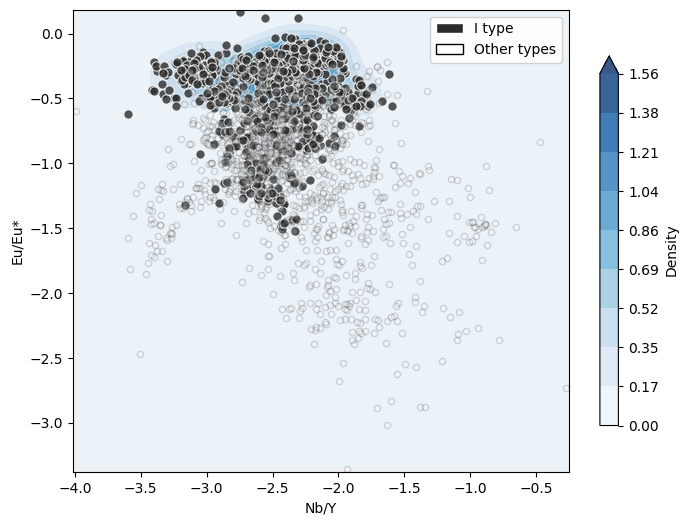

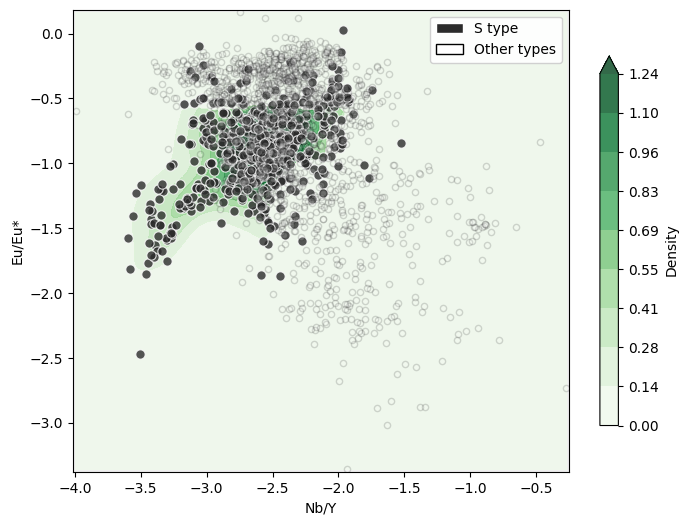

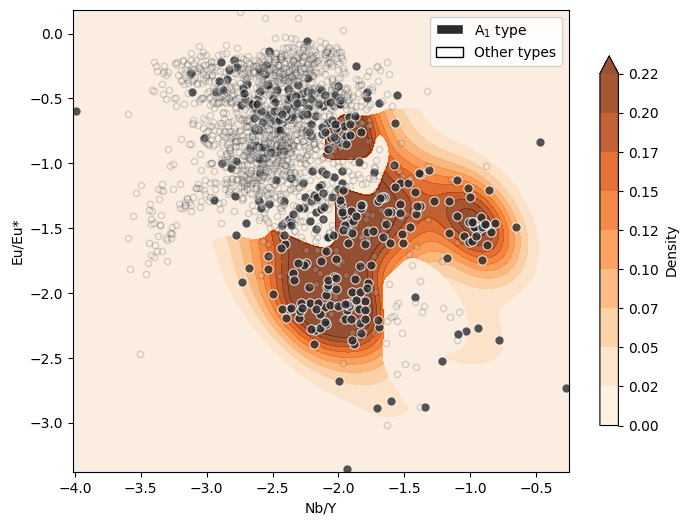

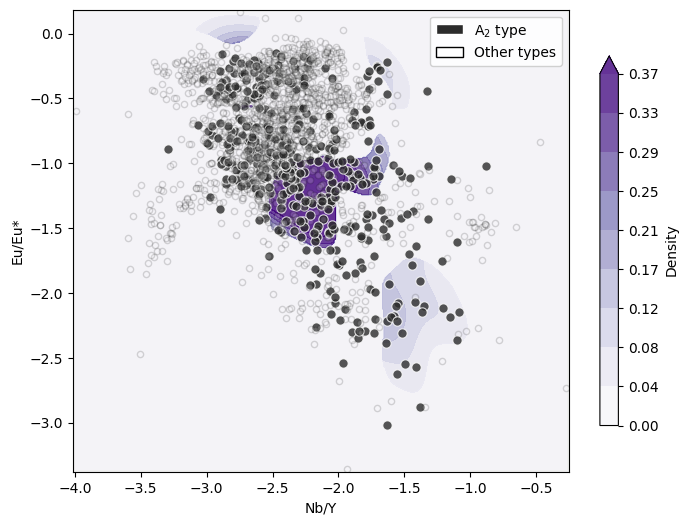

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
from scipy.ndimage import binary_closing
# --------------------------
# 数据预处理函数
# --------------------------
def calculate_type_weights(data, hue_order):
    """计算每种类型的样本权重"""
    return {hue: 1 / len(data[data["GRAINTETYPE"] == hue]) for hue in hue_order}

def perform_kde(data, hue_order, weights):
    """执行核密度估计"""
    kde_results = {}
    for hue in hue_order:
        mask = data["GRAINTETYPE"] == hue
        type_data = data[mask][['Nb/Y', "Eu/Eu*"]].values.T
        sample_weights = np.ones(len(data[mask])) * weights[hue]
        kde = gaussian_kde(type_data, bw_method='silverman', weights=sample_weights)
        kde_results[hue] = kde
    return kde_results

def create_grid(data, hue_order):
    """创建统一网格"""
    types_data = [data[data["GRAINTETYPE"] == hue][['Nb/Y', "Eu/Eu*"]].values.T for hue in hue_order]
    x_min = min(d[0].min() for d in types_data)
    x_max = max(d[0].max() for d in types_data)
    y_min = min(d[1].min() for d in types_data)
    y_max = max(d[1].max() for d in types_data)
    return np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))

# --------------------------
# 核心计算函数
# --------------------------
def calculate_densities(kde_dict, x_grid, y_grid, type_names):
    """计算网格点密度"""
    grid_points = np.vstack([x_grid.ravel(), y_grid.ravel()])
    return {type_names[hue]: kde(grid_points).reshape(x_grid.shape) for hue, kde in kde_dict.items()}

def calculate_non_overlap_densities(density_dict, hue_order, type_names):
    """修正后的非重叠区域计算"""
    non_overlap = {}
    for type1 in hue_order:
        type1_name = type_names[type1]
        mask = np.ones_like(density_dict[type1_name], dtype=bool)
        
        # 生成主导区域掩码
        for type2 in hue_order:
            if type1 != type2:
                type2_name = type_names[type2]
                mask &= (density_dict[type1_name] > density_dict[type2_name])
        structure = np.ones((2,2)) 
        mask = binary_closing(mask,structure = structure,iterations = 1)
        non_overlap[type1_name] = np.where(mask, density_dict[type1_name], 0)
    return non_overlap

def calculate_accuracy_probabilities(density_dict, x_grid, y_grid, type_names):
    """准确率计算（基于主导区域）"""
    dx = x_grid[0, 1] - x_grid[0, 0]
    dy = y_grid[1, 0] - y_grid[0, 0]
    
    # 确定主导类型矩阵
    type_matrix = np.zeros_like(x_grid, dtype=int)
    max_density = np.zeros_like(x_grid)
    for i, (_, name) in enumerate(type_names.items()):
        mask = density_dict[name] > max_density
        type_matrix[mask] = i
        max_density[mask] = density_dict[name][mask]
    
    # 计算各类型面积
    accuracy = {}
    total = 0.0
    for i, (_, name) in enumerate(type_names.items()):
        mask = (type_matrix == i)
        accuracy[name] = np.sum(density_dict[name][mask]) * dx * dy
        total += accuracy[name]
    
    return {k: v/total for k, v in accuracy.items()}

# --------------------------
# 可视化函数
# --------------------------
def plot_individual_density_maps(data_, density_dict, non_overlap_dict, x_grid, y_grid, type_names):
    """专业级单类型密度图绘制"""
    COLOR_SCHEME = {
        'I type': {'cmap': 'Blues', 'quantile': 0.95},
        'S type': {'cmap': 'Greens', 'quantile': 0.95},
        'A$_1$ type': {'cmap': 'Oranges', 'quantile': 0.9},
        'A$_2$ type': {'cmap': 'Purples', 'quantile': 0.85}
    }

    saved_paths = []
    
    for type_key, type_name in type_names.items():
        # 创建独立画布
        fig, ax = plt.subplots(figsize=(8, 6))
        cfg = COLOR_SCHEME[type_name]
        
        # 获取当前类型数据
        data = non_overlap_dict[type_name]
        current_mask = data_["GRAINTETYPE"] == type_key
        other_mask = ~current_mask

        # 动态计算颜色范围
        nonzero_data = data[data > 0]
        vmax = np.quantile(nonzero_data, cfg['quantile']) if len(nonzero_data) > 0 else 0.01
        levels = np.linspace(0, vmax, 10)

        # 绘制密度图
        contour = ax.contourf(x_grid, y_grid, data, levels=levels,
                            cmap=cfg['cmap'], alpha=0.8, extend='max')
        ax.set_facecolor('#f0f0f0')

        # 绘制数据点
        ax.scatter(data_[current_mask]['Nb/Y'], data_[current_mask]["Eu/Eu*"],
                  c='#2b2b2b', s=45, alpha=0.8, edgecolor='white', linewidth=0.8,
                  label=f'{type_name} (n={sum(current_mask)})')
        ax.scatter(data_[other_mask]['Nb/Y'], data_[other_mask]["Eu/Eu*"],
                  c='#ffffff', s=20, alpha=0.15, edgecolor='black')

        # 坐标轴设置
        ax.set(xlim=(x_grid.min()-0.02, x_grid.max()+0.02),
              ylim=(y_grid.min()-0.02, y_grid.max()+0.02),
              xlabel='Nb/Y',
              ylabel='Eu/Eu*')
        ax.tick_params(labelsize=10)

        # 颜色条
        cbar = fig.colorbar(contour, ax=ax, shrink=0.8, format='%.2f')
        cbar.set_label('Density', fontsize=10)

        # 图例
        handles = [
            Patch(facecolor='#2b2b2b', edgecolor='white', label=type_name),
            Patch(facecolor='#ffffff', edgecolor='black', label='Other types')
        ]
        ax.legend(handles=handles, loc='upper right', fontsize=10, framealpha=0.9)

        # 保存单独图片
        # filename = f"../Picture/Fig 6/Granitoid_{type_name.replace('$', '').replace(' ', '_')}.png"
        # plt.savefig(filename, dpi=600, bbox_inches='tight')
        # saved_paths.append(filename)
        # plt.close(fig)  # 关闭当前图形以释放内存

    return saved_paths
# --------------------------
# 主流程
# --------------------------
def main(data_):
    """主分析流程"""
    hue_order = ['I', 'S', 'A1', 'A2']
    type_names = {'I': 'I type', 'S': 'S type', 
                 'A1': 'A$_1$ type', 'A2': 'A$_2$ type'}
    
    weights = calculate_type_weights(data_, hue_order)
    print(weights)
    kde_dict = perform_kde(data_, hue_order, weights)
    print(kde_dict)
    x_grid, y_grid = create_grid(data_, hue_order)
    print(x_grid, y_grid)
    density_dict = calculate_densities(kde_dict, x_grid, y_grid, type_names)
    non_overlap_dict = calculate_non_overlap_densities(density_dict, hue_order, type_names)
    
    # 生成并保存单独图片
    saved_files = plot_individual_density_maps(data_, density_dict, non_overlap_dict, x_grid, y_grid, type_names)
    
    # 结果输出
    accuracy = calculate_accuracy_probabilities(density_dict, x_grid, y_grid, type_names)
    # print("\n生成的独立图片文件：")
    # for file in saved_files:
    #     print(f"-> {file}")
    
    return saved_files, accuracy
# 执行示例
if __name__ == "__main__":
    saved_files, probs = main(data_)
    print("\nClassification Confidence Scores:")
    print("{:<12} {:<8} {}".format("Type", "Score", "Interpretation"))
    print("-"*35)
    for name, prob in probs.items():
        print(f"{name:<12} {prob:.3f}    {interpret[name]} confidence")